In [43]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from tensorflow import keras
from keras import datasets, layers, models, losses
from random import choice

# for the clustering part
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

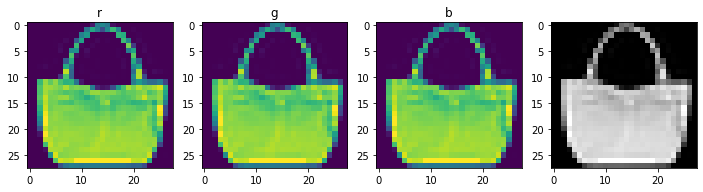

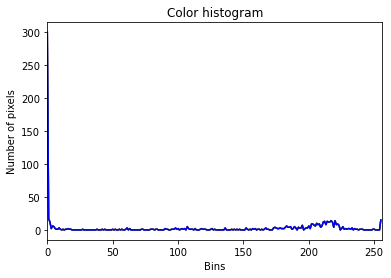

In [44]:
image_data = tf.keras.datasets.fashion_mnist
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

colors=("r", "g", "b")

# this will read the image passed and return a 3-channel histogram of it
#path = r"test_images/lenna.png"
#path = r"test_images/rgb_test.png"
#path = r"test_images/rgb_test2.webp"
#img = cv2.imread(path) # stores images in BGR format
#img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image_index = 100
img = train_img[image_index] #choice(train_img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

chans=cv2.split(img)

_, axs = plt.subplots(1, 4, figsize=(12, 12))
plt.imshow(img)
axs = axs.flatten() # works but vscode marks as an error for some reason
i = 0
for img, ax in zip(chans, axs):
    ax.set_title(colors[i])
    ax.imshow(img)
    i += 1
plt.show()

plt.figure()
plt.title("Color histogram")
plt.xlabel("Bins")
plt.ylabel("Number of pixels")
for (chan, c) in zip(chans, colors):
    hist=cv2.calcHist([chan], [0], None, [256], [0,256])
    plt.plot(hist, color=c)
    plt.xlim([0,256])
plt.show()

Color histograms

In [60]:
# this will divide every image in the training set into their respective channels and store them

color_representations = [] # a tuple in the form (label, image, [channels])

print(f"Dividing {len(train_img)} images into channels...")
for i in range(len(train_img)):
    chans=cv2.split(train_img[i])
    color_representations.append((train_labels[i], train_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

Dividing 60000 images into channels...
0 images divided
10000 images divided
20000 images divided
30000 images divided
40000 images divided
50000 images divided
60000 images divided, Done!


In [61]:
color_features = []
for i in range(len(color_representations)):
    image_colors = []
    for (channel, c) in zip(color_representations[i][2], colors):
        hist=cv2.calcHist([channel], [0], None, [256], [0,256])

        #list[i].extend(hist)
        image_colors.extend(hist)
        #image_colors.extend(hist)
        
    #list[i].extend(hist)
    color_features.append(image_colors)
color_features = np.squeeze(np.array(color_features))

Patches

0 images patched
10000 images patched
20000 images patched
30000 images patched
40000 images patched
50000 images patched
60000 images patched, Done!


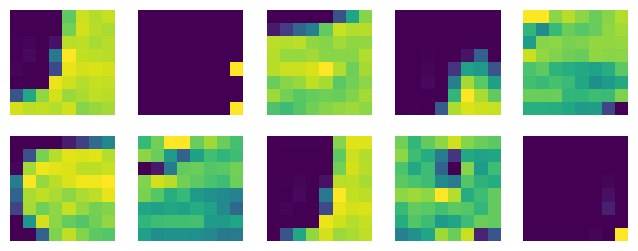

In [8]:
# returns a list of patches from the image passed
def get_patches(image, patch_size=8, n_patches=1000, random_state=10):
    patches = extract_patches_2d(image, patch_size=(patch_size, patch_size), max_patches=n_patches, random_state=10)
    return patches

# filling up the array with patches for each image
# also, both of these versions take the same amount of time to run :(

# version 1
patches_array = []
i = 0
for image in train_img:
    patches = get_patches(image)
    patches_array.append(patches)
    if i % 10000 == 0:
        print(f"{i} images patched")
    i += 1
print(f"{i} images patched, Done!")


# version 2
""" 
from joblib import Parallel, delayed
patches_array = Parallel(n_jobs=-1)(delayed(get_patches)(image) for image in train_img)
"""

# shows some of the patches
# the patches are taken from the image above
plt.figure(figsize=(8, 3))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(patches_array[image_index][i])
    plt.axis("off")


In [45]:
# now for the SIFT part
from PIL import Image

start = tf.timestamp()
sift = cv2.SIFT_create()
orb = cv2.ORB_create(scaleFactor=1.0, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)

""" 
# returns a tuple of (image, keypoints, descriptors) after applying sift or orb to the image passed
def get_keypoints_descriptors(img):
    # for sift
    img = cv2.resize(img, (480, 480)) # interpolation=cv2.INTER_LINEAR
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    
    # for orb
    #keypoints, descriptors = orb.detectAndCompute(img, None)
    #img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS

    return (img, keypoints, descriptors)
"""

sift_array = [] # a tuple in the form (image, keypoints, descriptors)
train_image_labels = [] #labels of images that had sift features
for i in range(len(train_img)):
    img = train_img[i]

    # resizing takes too much time, so I'll leave it at 2x
    #img = img.resize((480, 480))
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST) # interpolation=cv2.INTER_LINEAR
    #img = cv2.resize(image, (0, 0), fx = 2, fy = 2, interpolation=cv2.INTER_NEAREST)

    # for sift
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    if descriptors is not None: 
        sift_array.append((img, keypoints, descriptors)) #only add images for which keypoints and descriptors were found
        train_image_labels.append(train_labels[i]) #add label to list of labels of images used in training
    
    #sift_array.append(get_keypoints_descriptors(img))
    if i % 10000 == 0:
        print(f"{i} images described using sift")
    i += 1
print(f"{i} images described, Done!")
print('Feature extraction time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

# showing one example after training them all
img = sift_array[image_index][0]
""" img = train_img[image_index]
img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_LINEAR)
img = get_keypoints_descriptors(img)[0] """
cv2.imshow("Image", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


0 images described using sift
10000 images described using sift
20000 images described using sift
30000 images described using sift
40000 images described using sift
50000 images described using sift
60000 images described, Done!
Feature extraction time:76.91687202453613 seconds


Bag of visual words from the SIFT features

In [46]:
from sklearn.cluster import KMeans

features = [] #array of feature descriptions
for i in range(len(sift_array)):
    features.append(sift_array[i][2])
features = np.vstack(features) #list to stack



n_clusters = 20 #20 clusters of features
kmeans = KMeans(n_clusters)
clustered = kmeans.fit_predict(features)

#creating the BOV
n_images = len(sift_array) #all the images we have features for
histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
old_count = 0
for i in range(n_images):
    #if sift_array[i][2] is not None:
    l = len(sift_array[i][2]) #l is number of feature descriptors in image i
    for j in range(l):
        idx = clustered[old_count+j] #find those feature descriptors from clustered features
        histogram[i][idx] += 1 
    old_count += l #current position in clustered

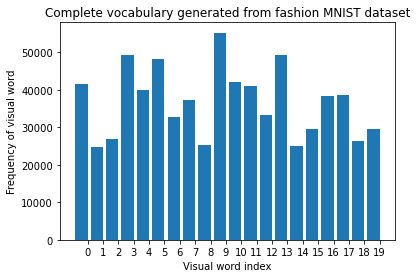

In [47]:
#visualize the vocabulary we have
x_scalar = np.arange(n_clusters)
y_scalar = np.array([abs(np.sum(histogram[:,h], dtype=np.int32)) for h in range(n_clusters)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual word index")
plt.ylabel("Frequency of visual word")
plt.title("Complete vocabulary generated from fashion MNIST dataset")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler().fit(histogram)
histogram = scale.transform(histogram)

Classification: SVM

In [49]:
from sklearn.svm import SVC
svm = SVC()
start = tf.timestamp()
svm.fit(histogram,train_image_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:357.24351811408997 seconds


Testing: SIFT features

In [50]:
sift_array_test = [] # a tuple in the form (image, keypoints, descriptors)
test_image_labels = []
for i in range(len(test_img)):
    img = test_img[i]

    # resizing takes too much time, so I'll leave it at 2x
    #img = img.resize((480, 480))
    img = cv2.resize(img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST) # interpolation=cv2.INTER_LINEAR
    #img = cv2.resize(image, (0, 0), fx = 2, fy = 2, interpolation=cv2.INTER_NEAREST)

    # sift features for the test images
    keypoints, descriptors = sift.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints, None) # flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    if descriptors is not None:
        sift_array_test.append((img, keypoints, descriptors))
        test_image_labels.append(test_labels[i])

In [51]:
test_features = []
#test_vStack = np.array(sift_array_test[0][2])
for i in range(len(sift_array_test)):
	test_features.append(sift_array_test[i][2]) #add feature descriptions
test_features = np.vstack(test_features)

In [52]:
#creating vocabulary for testing: 
test_kmeans = kmeans.predict(test_features)

#create bag of words from test images
n_test_images = len(sift_array_test)
test_vocab = np.array([np.zeros(n_clusters) for i in range(n_test_images)])
old_count = 0
for i in range(n_test_images):
    #if sift_array_test[i][2] is not None:
    l = len(sift_array_test[i][2]) #descriptor array of image i
    for j in range(l):
        idx = test_kmeans[old_count+j]
        test_vocab[i][idx] += 1
    old_count += l

#scale using the scaler fit on training data
test_vocab = scale.transform(test_vocab)

In [53]:
start = tf.timestamp()
y_pred = svm.predict(test_vocab)
print('Testing time: '+ str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Testing time: 121.3529360294342 seconds


<AxesSubplot:title={'center':'Fashion MNIST dataset, SIFT features, svm'}>

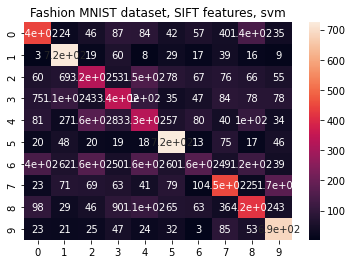

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusionmatrix = confusion_matrix(test_image_labels, y_pred)
plt.title('Fashion MNIST dataset, SIFT features, svm')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Fashion MNIST dataset: SVM on SIFT features with default parameters:')
print('Accuracy: ' + str(accuracy_score(test_image_labels,y_pred)))
print('Precision: ' + str(precision_score(test_image_labels,y_pred,average='macro')))
print('Recall: ' + str(recall_score(test_image_labels,y_pred,average='macro')))

Fashion MNIST dataset: SVM on SIFT features with default parameters:
Accuracy: 0.46399757966922145
Precision: 0.44790513510567714
Recall: 0.46646625518026175


Decision trees

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
start = tf.timestamp()
dt.fit(histogram, train_image_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:0.4033188819885254 seconds


In [57]:
start = tf.timestamp()
y_pred_dt = dt.predict(test_vocab)
print('Testing time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Testing time:0.00446319580078125 seconds


<AxesSubplot:title={'center':'FashionMNIST dataset, SIFT features, decision tree with default params'}>

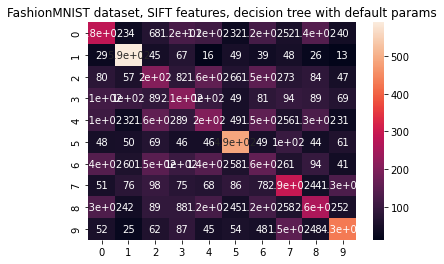

In [58]:
confusionmatrix = confusion_matrix(test_image_labels, y_pred_dt)
plt.title('FashionMNIST dataset, SIFT features, decision tree with default params')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)

In [59]:
print('Decision tree on SIFT features with default parameters:')
print('Accuracy: ' + str(accuracy_score(test_image_labels,y_pred_dt)))
print('Precision: ' + str(precision_score(test_image_labels,y_pred_dt,average='macro')))
print('Recall: ' + str(recall_score(test_image_labels,y_pred_dt,average='macro')))

Decision tree on SIFT features with default parameters:
Accuracy: 0.31444130697862044
Precision: 0.3144400218555458
Recall: 0.3169731467623975


Color histograms as features

In [62]:
from sklearn.svm import SVC
svm = SVC()
start = tf.timestamp()
svm.fit(color_features, train_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:1057.0791018009186 seconds


In [63]:
color_representations_test = [] # a tuple in the form (label, image, [channels])


print(f"Dividing {len(test_img)} images into channels...")
for i in range(len(test_img)):
    chans=cv2.split(test_img[i])
    color_representations_test.append((test_labels[i], test_img[i], chans))
    if i % 10000 == 0:
        print(f"{i} images divided")
print(f"{i+1} images divided, Done!")

color_histograms_test = []
for i in range(len(color_representations_test)):
    image_colors = []
    for (channel, c) in zip(color_representations_test[i][2], colors):
        hist=cv2.calcHist([channel], [0], None, [256], [0,256])
        image_colors.extend(hist)
    color_histograms_test.append(image_colors)
color_histograms_test = np.squeeze(np.array(color_histograms_test))

Dividing 10000 images into channels...
0 images divided
10000 images divided, Done!


In [64]:
start = tf.timestamp()
y_pred = svm.predict(color_histograms_test)
print('Testing time: '+ str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')


Testing time: 261.5455548763275 seconds


SVM on color histograms with default params
Accuracy: 0.4965
Precision: 0.49255662313433907
Recall: 0.4965


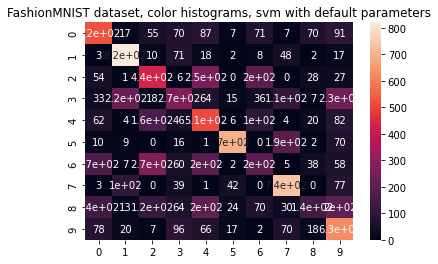

In [65]:

confusionmatrix = confusion_matrix(test_labels, y_pred)
plt.title('FashionMNIST dataset, color histograms, svm with default parameters')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)
print('SVM on color histograms with default params')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred)))
print('Precision: ' + str(precision_score(test_labels,y_pred,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred,average='macro')))

In [66]:
dt = DecisionTreeClassifier()
start = tf.timestamp()
dt.fit(color_features, train_labels)
print('Training time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')

Training time:10.364255905151367 seconds


In [67]:
start = tf.timestamp()
y_pred_dt = dt.predict(color_histograms_test)
print('Testing time:' +str(tf.get_static_value(tf.timestamp()-start))+ ' seconds')


Testing time:0.007965803146362305 seconds


Decision tree trained on color histograms with default params
Accuracy: 0.4059
Precision: 0.4057836291761562
Recall: 0.40590000000000004


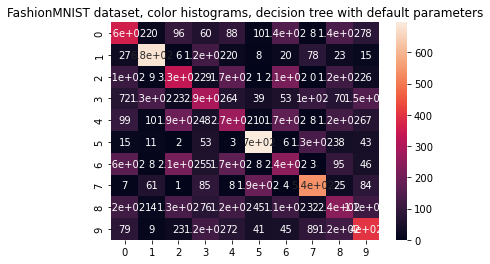

In [68]:
confusionmatrix = confusion_matrix(test_labels, y_pred_dt)
plt.title('FashionMNIST dataset, color histograms, decision tree with default parameters')
plt.xlabel('Predicted class')
plt.ylabel('True class')
sns.heatmap(confusionmatrix,annot=True)
print('Decision tree trained on color histograms with default params')
print('Accuracy: ' + str(accuracy_score(test_labels,y_pred_dt)))
print('Precision: ' + str(precision_score(test_labels,y_pred_dt,average='macro')))
print('Recall: ' + str(recall_score(test_labels,y_pred_dt,average='macro')))